In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import sys
sys.path.append(os.path.join(os.getcwd(), '..', 'utils'))
from compute_tau import compute_tau_star
import seaborn as sns
sns.set()
sns.set_style("whitegrid",  {"grid.linewidth": 0.6})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
figsize = (8, 6)
cmap = plt.get_cmap("tab10")
cmap2 = plt.get_cmap("tab20")
contour_cmap = plt.cm.get_cmap('Greys_r')
contour_points = 100000
alpha = .6
fig_dir = os.path.join(os.getcwd(), 'dirac_figs')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
ms=15
ms2=20
density = 1.25
ls=20
fs=30
fs2=24
lsp=0.1
htp=.1
ms3=.5
mew=2
slw = 2.5
show=True
save=False
lw=4
frameon=False

## Game and Derivatives

In [2]:
def fp(x):
    return 1/(1+np.exp(x))

def d1f1_func_gan(x, y, reg):
    return y*fp(x*y)
    
def d2f2_func_gan(x, y, reg):
    return -x*fp(x*y) + reg*y

def d1f1_func_nsgan(x, y, reg):  
    return y*fp(-x*y)

def d2f2_func_nsgan(x, y, reg):
    return -x*fp(x*y) + reg*y

## Dynamics

In [3]:
def run_dynamics(d1f1_func, d2f2_func, reg=0.3, learning_rate=0.01, tau_list=[1, 4, 8, 16], num_epochs=4000):

    x_init = 1
    y_init = 1

    trajectories = []

    for tau in tau_list:

        trajectory = []
        x = np.array([x_init])
        y = np.array([y_init])

        z = np.concatenate([x, y]).flatten()

        trajectory.append(z)
        start = time.time()

        for epoch in range(1, num_epochs+1):

            d1f1 = d1f1_func(x, y, reg)             
            d2f2 = d2f2_func(x, y, reg)
            x = x - learning_rate * d1f1
            y = y - tau*learning_rate * d2f2

            z = np.concatenate([x, y])
            trajectory.append(z)

        trajectory = np.vstack(trajectory)
        trajectories.append(trajectory)

    return trajectories

## Plotting Functions

In [4]:
def plot_trajectories(trajectories, name, xlims=None, ylims=None):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    critical_point = [0,  0]

    for i, trajectory in enumerate(trajectories):
        ax.plot(trajectory[:, 0], trajectory[:, 1], color=cmap(i), lw=lw)

    ax.plot(trajectory[0, 0], trajectory[0, 1], color='black', marker='o', markersize=ms, ls='none', label=r'$(\theta_0, \omega_0)$')
    ax.plot(critical_point[0], critical_point[1], color='black', marker='*', markersize=ms2, ls='none', label=r'LNE')       
    ax.set_xlabel(r'$\theta$', fontsize=fs)
    ax.set_ylabel(r'$\omega$', fontsize=fs)
    
    if xlims is not None and ylims is not None:
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
    ax.tick_params(labelsize=ls)
    plt.legend(fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp, loc='best')
    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(fig_dir, name+'_x_y.png'), bbox_inches='tight')
    if show:
        plt.show()
        
def plot_distance_to_equilibria(trajectories, name):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    critical_point = [0,  0]
    for i, trajectory in enumerate(trajectories):
        ax.plot(np.abs(trajectory[:, 0]-critical_point[0]), color=cmap(i), lw=lw, ls='-')
        ax.plot(np.abs(trajectory[:, 1]-critical_point[1]), color=cmap(i), lw=lw, ls='--')       
    ax.set_xlabel('Iterations', fontsize=fs)
    ax.tick_params(labelsize=ls)
    ax.plot([], [], color='black', label=r'$||\theta-\theta^{\ast}||_2$', ls='-', lw=lw)
    ax.plot([], [], color='black', label=r'$||\omega-\omega^{\ast}||_2$', ls='--', lw=lw)
    plt.legend(fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp, loc='lower left')
    ax.set_yscale('log')
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(fig_dir, name + '_distance.png'), bbox_inches='tight')
    if show:
        plt.show()
        
def plot_vector_field(trajectories, d1f1_func, d2f2_func, name, tau_list=[1, 4, 8, 16], reg=0.3):
    fig, ax = plt.subplots(1, len(tau_list), figsize=(8*len(tau_list), 8), sharex=True, sharey=True)
    xlims = [-2, 2]
    ylims = [-2, 2]
    for count, tau in enumerate(tau_list):
        if type(reg) is list:
            reg_value = reg[count]
        else:
            reg_value = reg
        x, y = np.meshgrid(np.linspace(xlims[0],xlims[1], int(np.sqrt(contour_points))), np.linspace(ylims[0], ylims[1], int(np.sqrt(contour_points))))
        z1 = -d1f1_func(x, y, reg_value)
        z2 = -tau*d2f2_func(x, y, reg_value)
        z3 = np.sqrt(z1**2 + z2**2)
        z3 = z3/z3.max()
        ax[count].streamplot(x, y, z1, z2, color=z3, cmap=contour_cmap, density=density, linewidth=slw, arrowsize=2)
        trajectory = trajectories[count]
        ax[count].plot(trajectory[:, 0], trajectory[:, 1], color=cmap(count), lw=lw*2)
        ax[count].plot(trajectory[-1, 0], trajectory[-1, 1], color=cmap(count), markeredgecolor='black', marker='*', markersize=ms2*1.5, ls='none', markeredgewidth=mew)
        ax[count].plot(trajectory[0, 0], trajectory[0, 1], color=cmap(count), markeredgecolor='black', marker='o', markersize=ms*1.5, ls='none', markeredgewidth=mew)
        ax[count].set_xlim(xlims)
        ax[count].set_ylim(ylims)
        ax[count].tick_params(labelsize=ls*1.5)
        if type(reg) is list:
            ax[count].set_xlabel(r'$\tau=%d, \mu=%.1f$'%(tau, reg_value), fontsize=fs*1.5)
        else:
            ax[count].set_xlabel(r'$\tau=%d$'%tau, fontsize=fs*1.5)

    fig.text(0.52, -0.035, r'$\theta$', ha='center', fontsize=fs*1.5)
    fig.text(-0.02, 0.5, r'$\omega$', va='center', rotation='vertical', fontsize=fs*1.5)
    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(fig_dir, name + '_vfield.png'), bbox_inches='tight')
    if show:
        plt.show()

## Run Simulation and Generator Plots

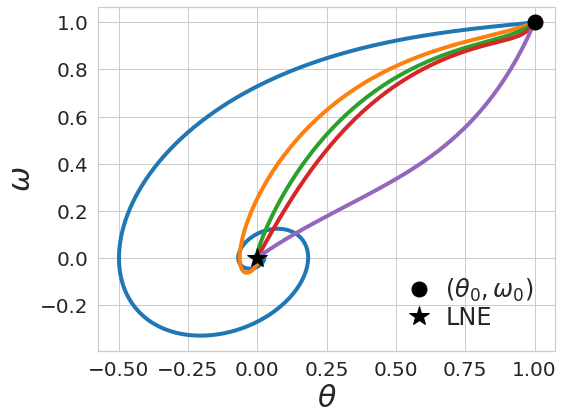

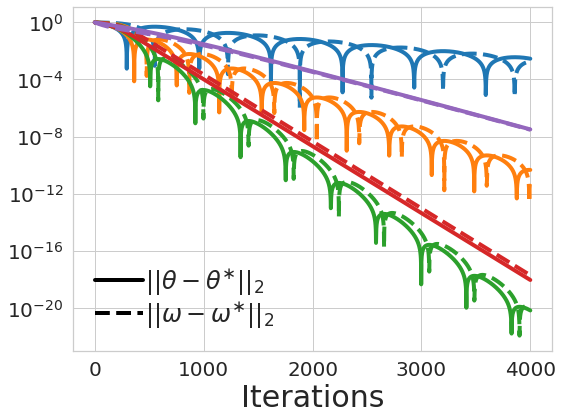

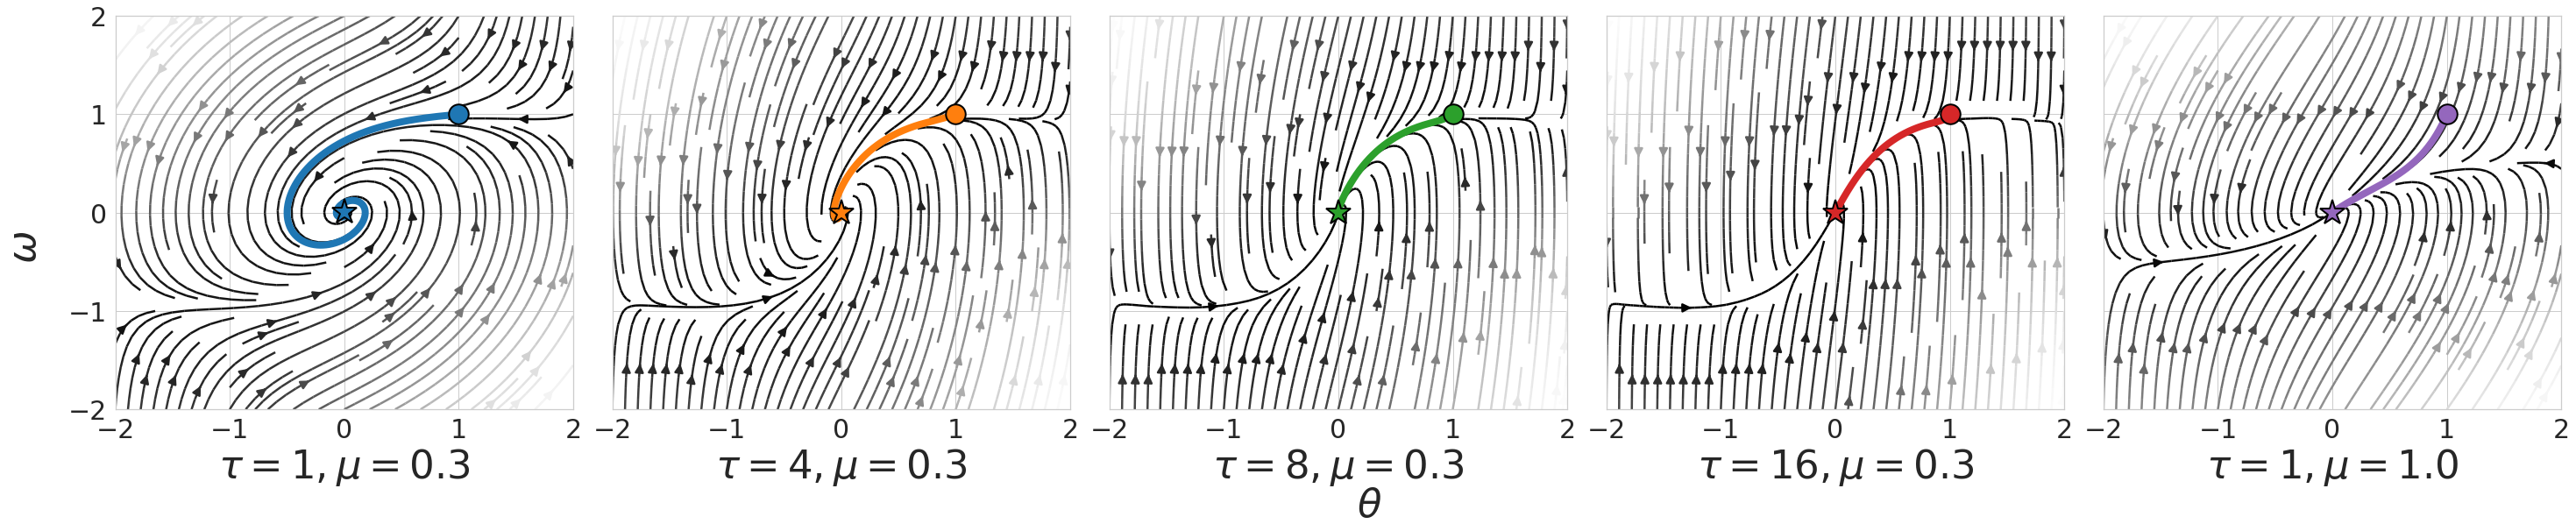

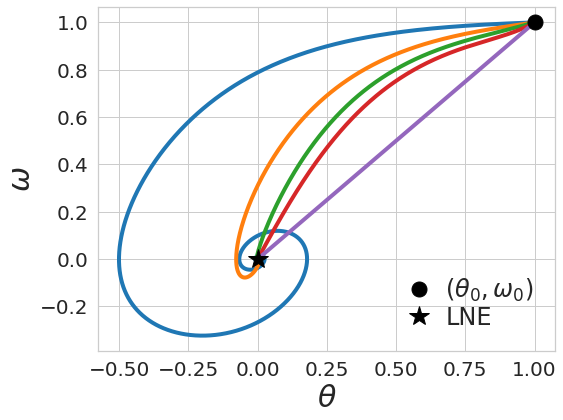

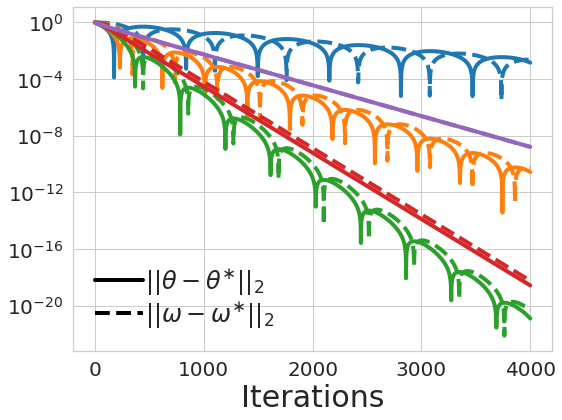

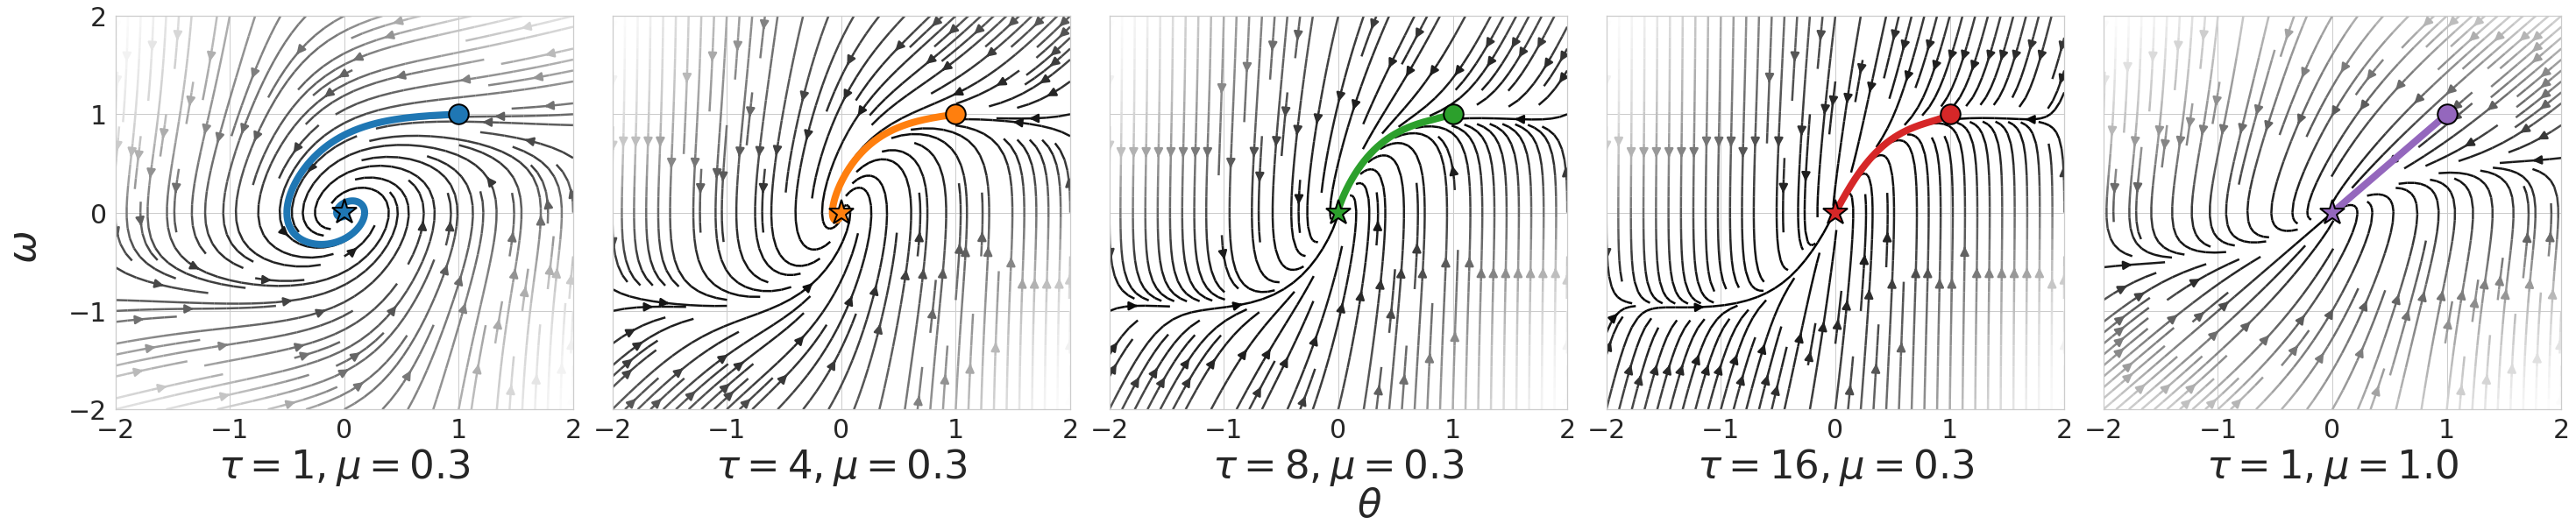

In [5]:
for d1f1_func, d2f2_func, name in zip([d1f1_func_gan, d1f1_func_nsgan], [d2f2_func_gan, d2f2_func_nsgan], ['gan_03', 'nsgan_03']):
    trajectories = run_dynamics(d1f1_func, d2f2_func, reg=0.3, tau_list=[1, 4, 8, 16])
    trajectories_critical = run_dynamics(d1f1_func, d2f2_func, reg=1.0, tau_list=[1])
    
    plot_trajectories(trajectories+trajectories_critical, name)
    plot_distance_to_equilibria(trajectories+trajectories_critical, name)
    plot_vector_field(trajectories+trajectories_critical, d1f1_func, d2f2_func, name, tau_list=[1, 4, 8, 16, 1], reg=[0.3, 0.3, 0.3, 0.3, 1])

# Plot Eigenvalues

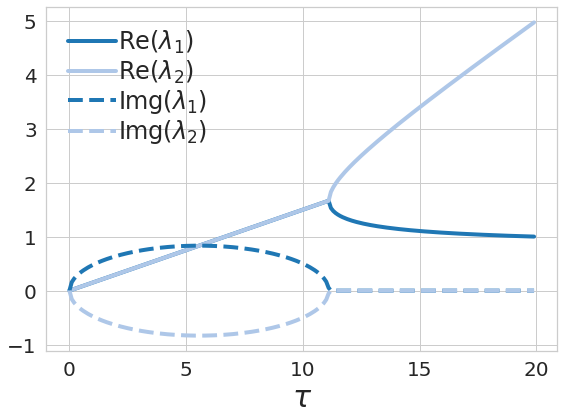

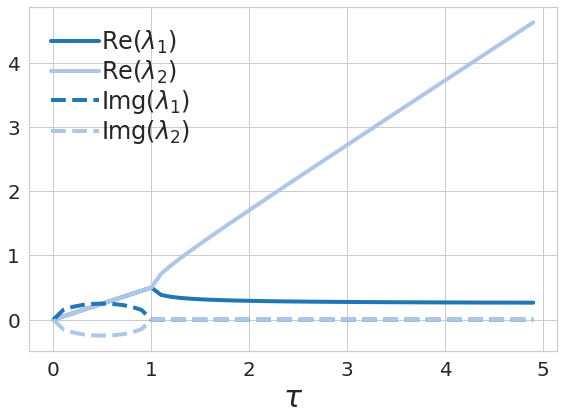

In [6]:
tau_min = 0
tau_max = 20
tau_step = .1
reg = 0.3
x, y = [0, 0]
tau_sweep = np.arange(tau_min, tau_max, tau_step)
eigs = [np.linalg.eigvals(np.array([[0, 1/2], [-tau*1/2, tau*reg]])) for tau in tau_sweep]
eigs = np.vstack(eigs)

fig, ax = plt.subplots(1, 1, figsize=figsize)

ax.plot(tau_sweep, np.real(eigs[:, 0]), '-', lw=lw, color=cmap2(0), markersize=ms3, label=r'Re($\lambda_1$)')
ax.plot(tau_sweep, np.real(eigs[:, 1]), '-', lw=lw, color=cmap2(1), markersize=ms3, label=r'Re($\lambda_2$)')

ax.plot(tau_sweep, np.imag(eigs[:, 0]), '-', lw=lw, color=cmap2(0), markersize=ms3, label=r'Img($\lambda_1)$', ls='--')
ax.plot(tau_sweep, np.imag(eigs[:, 1]), '-', lw=lw, color=cmap2(1), markersize=ms3, label=r'Img($\lambda_2)$', ls='--')
ax.set_xlabel(r'$\tau$', fontsize=fs)
ax.tick_params(labelsize=ls)
ax.legend(fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp)
plt.tight_layout()

if save:
    plt.savefig(os.path.join(fig_dir, 'tau_eig_sweep2_reg1.png'), bbox_inches='tight')
if show:
    plt.show()

tau_min = 0
tau_max = 5
tau_step = .1
reg = 1.0
x, y = [0, 0]
tau_sweep = np.arange(tau_min, tau_max, tau_step)
eigs = [np.linalg.eigvals(np.array([[0, -1/2], [tau*1/2, tau*reg]])) for tau in tau_sweep]
eigs = np.vstack(eigs)

fig, ax = plt.subplots(1, 1, figsize=figsize)

ax.plot(tau_sweep, np.real(eigs[:, 0]), '-', lw=lw, color=cmap2(0), markersize=ms3, label=r'Re($\lambda_1$)')
ax.plot(tau_sweep, np.real(eigs[:, 1]), '-', lw=lw, color=cmap2(1), markersize=ms3, label=r'Re($\lambda_2$)')

ax.plot(tau_sweep, np.imag(eigs[:, 0]), '-', lw=lw, color=cmap2(0), markersize=ms3, label=r'Img($\lambda_1)$', ls='--')
ax.plot(tau_sweep, np.imag(eigs[:, 1]), '-', lw=lw, color=cmap2(1), markersize=ms3, label=r'Img($\lambda_2)$', ls='--')
ax.set_xlabel(r'$\tau$', fontsize=fs)
ax.tick_params(labelsize=ls)
ax.legend(fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp)
plt.tight_layout()

if save:
    plt.savefig(os.path.join(fig_dir, 'tau_eig_sweep2_reg2.png'), bbox_inches='tight')
if show:
    plt.show()

## Compute $\tau^{\ast}$

In [7]:
m = 1
n = 1
for reg in [0.3, 1]:
    x, y = [0, 0]
    J = np.array([[0, 1/2], [-1/2, reg]])
    tau_star = compute_tau_star(J, m, n)
    if type(tau_star) is str:
        print('critical point (x, y) = ({:.2f}, {:.2f}):'.format(x, y), tau_star)
    else:
        print(r'tau = {:.2f}'.format(tau_star), '@ critical point (x, y) = ({:.2f}, {:.2f})'.format(x, y))

tau = 0.00 @ critical point (x, y) = (0.00, 0.00)
tau = 0.00 @ critical point (x, y) = (0.00, 0.00)
